In [18]:
# ---------------------- Markdown ----------------------
# # Combined Dataset Classifier
# This notebook section prepares a combined dataset of real and synthetic images for classifier training. 
# It ensures that only existing images are used and avoids empty folders that cause `num_samples=0` errors.

# ---------------------- Code ----------------------
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------
# Paths & class names
# ----------------------
WORK_DIR = "./combined_data"
REAL_DIRS = [
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
]
SYNTH_DIR = "./synthetic"  # your GAN output folder
CLASS_NAMES = ["akiec","bcc","bkl","df","mel","nv","vasc"]

# ----------------------
# Create combined folder structure safely
# ----------------------
os.makedirs(WORK_DIR, exist_ok=True)
for cls in CLASS_NAMES:
    os.makedirs(os.path.join(WORK_DIR, cls), exist_ok=True)

# ----------------------
# Copy images only if they exist
# ----------------------
def copy_images(src_root, dst_root, class_names):
    for cls in class_names:
        src_dir = os.path.join(src_root, cls)
        dst_dir = os.path.join(dst_root, cls)
        if os.path.exists(src_dir):
            for f in os.listdir(src_dir):
                if f.lower().endswith(('.png','.jpg','.jpeg')):
                    shutil.copy(os.path.join(src_dir,f), dst_dir)

for real_dir in REAL_DIRS:
    copy_images(real_dir, WORK_DIR, CLASS_NAMES)

if os.path.exists(SYNTH_DIR):
    copy_images(SYNTH_DIR, WORK_DIR, CLASS_NAMES)

# ----------------------
# Dataset class
# ----------------------
class CombinedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {cls:i for i, cls in enumerate(sorted(os.listdir(root_dir)))}
        for cls in os.listdir(root_dir):
            cls_folder = os.path.join(root_dir, cls)
            imgs_in_cls = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
            if len(imgs_in_cls)==0:  # skip empty class
                print(f"Skipping empty class folder: {cls_folder}")
                continue
            for f in imgs_in_cls:
                self.image_paths.append(os.path.join(cls_folder,f))
                self.labels.append(self.class_to_idx[cls])
        self.transform = transform
        if len(self.image_paths)==0:
            raise ValueError(f"No images found in {root_dir}!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# ----------------------
# Transform & DataLoader
# ----------------------
clf_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = CombinedDataset(WORK_DIR, transform=clf_transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# ----------------------
# Simple CNN classifier
# ----------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ----------------------
# Train classifier
# ----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"[Classifier] Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

# ----------------------
# Visualize predictions
# ----------------------
imgs, labels = next(iter(dataloader))
outputs = model(imgs.to(device))
preds = torch.argmax(outputs, dim=1)
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(((imgs[i].permute(1,2,0)+1)/2).numpy())
    plt.title(f"Pred:{preds[i].item()} | True:{labels[i].item()}")
    plt.axis('off')
plt.show()
print("Classifier training complete with real+synthetic images!")


Skipping empty class folder: ./combined_data/bkl
Skipping empty class folder: ./combined_data/bcc
Skipping empty class folder: ./combined_data/akiec
Skipping empty class folder: ./combined_data/nv
Skipping empty class folder: ./combined_data/df
Skipping empty class folder: ./combined_data/vasc
Skipping empty class folder: ./combined_data/mel


ValueError: No images found in ./combined_data!

In [9]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image

# ----------------------
# Dataset + Augmentations (both folders)
# ----------------------
class CustomDataset(Dataset):
    def __init__(self, image_dirs, transform=None):
        self.image_paths = []
        for dir_path in image_dirs:
            # Only include image files
            self.image_paths += [os.path.join(dir_path, f) 
                                 for f in os.listdir(dir_path) 
                                 if f.lower().endswith(('.png','.jpg','.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# ----------------------
# Augmentations
# ----------------------
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ----------------------
# Dataset + DataLoader
# ----------------------
dataset = CustomDataset([
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
], transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# ----------------------
# Generator + Discriminator
# ----------------------
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 3*128*128),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1,3,128,128)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*128*128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

G = Generator().cuda()
D = Discriminator().cuda()

# ----------------------
# Loss + Optimizers + Scheduler
# ----------------------
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.8)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=10, gamma=0.8)

# ----------------------
# Training Loop
# ----------------------
epochs = 10
latent_dim = 100

for epoch in range(epochs):
    for imgs in dataloader:
        batch_size = imgs.size(0)
        real_imgs = imgs.cuda()

        # ----------------------
        # Train Discriminator
        # ----------------------
        optimizer_D.zero_grad()
        # Label smoothing
        real_labels = torch.ones(batch_size,1).cuda() * 0.9
        fake_labels = torch.zeros(batch_size,1).cuda() + 0.1

        # Real images with small noise
        output_real = D(real_imgs + 0.05*torch.randn_like(real_imgs))
        d_real_loss = criterion(output_real, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_dim).cuda()
        fake_imgs = G(z)
        output_fake = D(fake_imgs.detach() + 0.05*torch.randn_like(fake_imgs))
        d_fake_loss = criterion(output_fake, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ----------------------
        # Train Generator
        # ----------------------
        optimizer_G.zero_grad()
        output = D(fake_imgs)
        g_loss = criterion(output, real_labels)  # generator wants discriminator to predict as real
        g_loss.backward()
        optimizer_G.step()

    # Step schedulers
    scheduler_G.step()
    scheduler_D.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save generated samples every 2 epochs
    if (epoch+1) % 2 == 0:
        save_image(fake_imgs[:16], f"generated_epoch_{epoch+1}.png", nrow=4, normalize=True)

print("Training completed!")


Epoch [1/10] | D Loss: 1.0980 | G Loss: 1.3772
Epoch [2/10] | D Loss: 0.8046 | G Loss: 1.5558
Epoch [3/10] | D Loss: 0.9727 | G Loss: 1.3205
Epoch [4/10] | D Loss: 0.9963 | G Loss: 1.3619
Epoch [5/10] | D Loss: 0.8252 | G Loss: 1.1336
Epoch [6/10] | D Loss: 0.8234 | G Loss: 1.2473
Epoch [7/10] | D Loss: 0.8758 | G Loss: 1.2633
Epoch [8/10] | D Loss: 0.7894 | G Loss: 1.3365
Epoch [9/10] | D Loss: 0.8789 | G Loss: 1.3013
Epoch [10/10] | D Loss: 0.8902 | G Loss: 0.8529
Training completed!


Models saved successfully!
New sample images generated and saved!


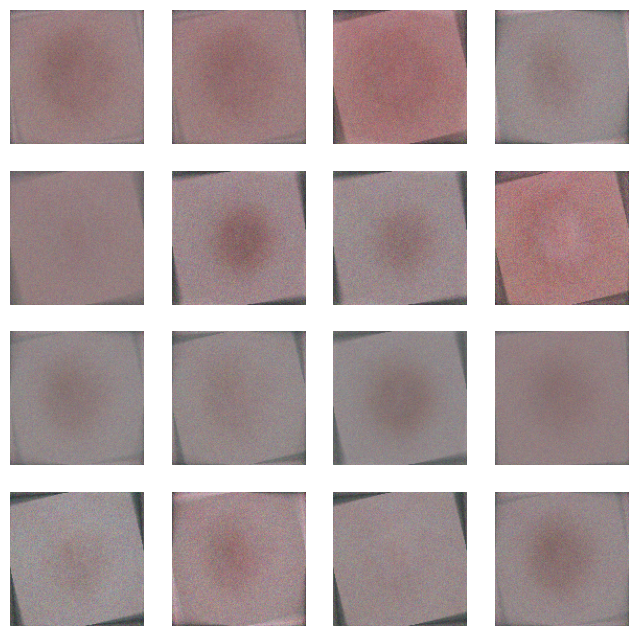

In [10]:
# ----------------------
# Save trained models
# ----------------------
torch.save(G.state_dict(), "generator.pth")
torch.save(D.state_dict(), "discriminator.pth")
print("Models saved successfully!")

# ----------------------
# Generate new images (inference)
# ----------------------
G.eval()  # set generator to evaluation mode
num_samples = 16  # number of images to generate
z = torch.randn(num_samples, latent_dim).cuda()

with torch.no_grad():
    generated_imgs = G(z)

save_image(generated_imgs, "generated_new_samples.png", nrow=4, normalize=True)
print("New sample images generated and saved!")

# ----------------------
# Optional: Visualize generated images inline (if using notebook)
# ----------------------
import matplotlib.pyplot as plt
import numpy as np

def imshow(img_tensor):
    img = img_tensor.cpu().numpy()
    img = np.transpose(img, (1,2,0))  # C,H,W -> H,W,C
    img = (img + 1)/2  # denormalize from [-1,1] to [0,1]
    plt.imshow(img)
    plt.axis('off')

plt.figure(figsize=(8,8))
for i in range(num_samples):
    plt.subplot(4,4,i+1)
    imshow(generated_imgs[i])
plt.show()


In [13]:
# stgan_kaggle_friendly_patchgan.py
# Kaggle-friendly STGAN-lite: two-stage GAN with Freeze-D + Barlow Twins (SSL) + PatchGAN

import os, shutil, random, math, time
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.utils import save_image

# ---------------------------
# Config
# ---------------------------
DATA_DIRS = [
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
]
METADATA_CSV = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

WORK_DIR = "/kaggle/working/stgan_lite_patchgan"
REAL_IMGS_DIR = os.path.join(WORK_DIR, 'real_images')
STAGE1_DIR = os.path.join(WORK_DIR, 'stage1')
STAGE2_DIR = os.path.join(WORK_DIR, 'stage2')
SYNTH_DIR = os.path.join(WORK_DIR, 'synth')
COMBINED_DIR = os.path.join(WORK_DIR, 'combined')
CLASS_NAMES = ["akiec","bcc","bkl","df","mel","nv","vasc"]
IMG_SIZE = 128
BATCH = 32
LATENT_DIM = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)
os.makedirs(WORK_DIR, exist_ok=True)

# ---------------------------
# Helpers
# ---------------------------
def organize_ham10000(image_dirs, metadata_csv, out_dir):
    import csv
    meta = Path(metadata_csv)
    if not meta.exists(): 
        print("Metadata CSV not found!"); return
    outp = Path(out_dir)
    outp.mkdir(parents=True, exist_ok=True)
    for c in CLASS_NAMES: (outp/c).mkdir(exist_ok=True)
    mapping = {}
    with open(meta,'r') as f:
        reader = csv.DictReader(f)
        for r in reader: mapping[r['image_id']] = r['dx'].lower()
    for data_dir in image_dirs:
        for img_path in Path(data_dir).glob("*"):
            if img_path.suffix.lower() in ['.jpg','.jpeg','.png']:
                id = img_path.stem
                if id in mapping and mapping[id] in CLASS_NAMES:
                    dst = Path(out_dir)/mapping[id]/img_path.name
                    if not dst.exists(): shutil.copy(img_path, dst)
    print("Organized images under", out_dir)

class ImgFolderDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = list(Path(folder).rglob("*.jpg")) + list(Path(folder).rglob("*.png"))
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

# ---------------------------
# Barlow Twins memory-safe feature extractor
# ---------------------------
def compute_barlow_features(x):
    # Downsample to 8x8 grid to reduce memory
    x = nn.functional.adaptive_avg_pool2d(x, 8)
    return x.view(x.size(0), -1)  # batch x (channels*8*8)

# ---------------------------
# Main pipeline
# ---------------------------
def main_pipeline():
    if not Path(REAL_IMGS_DIR).exists() or not any(Path(REAL_IMGS_DIR).iterdir()):
        organize_ham10000(DATA_DIRS, METADATA_CSV, REAL_IMGS_DIR)
    
    # Load dataset
    tf = get_gan_transforms(IMG_SIZE)
    ds_all = ImgFolderDataset(REAL_IMGS_DIR, transform=tf)
    dl_all = DataLoader(ds_all, batch_size=BATCH, shuffle=True, drop_last=True)
    print("Stage1 dataset size:", len(ds_all))

    # Stage1 GAN
    G = SimpleGenerator(LATENT_DIM,img_size=IMG_SIZE)
    D = PatchDiscriminator()
    G,D = train_gan_stage1(G,D,dl_all,epochs=4,lr=2e-4,save_dir=STAGE1_DIR)
    
    lastG = sorted(Path(STAGE1_DIR).glob("G_epoch*.pth"))[-1]
    lastD = sorted(Path(STAGE1_DIR).glob("D_epoch*.pth"))[-1]

    # Stage2 GAN per class (memory optimized)
    for cls in CLASS_NAMES:
        class_folder = os.path.join(REAL_IMGS_DIR, cls)
        if not Path(class_folder).exists() or len(list(Path(class_folder).glob('*')))<10: continue
        outroot = os.path.join(STAGE2_DIR,cls); os.makedirs(outroot, exist_ok=True)
        stage2_batch = min(16, max(4, len(list(Path(class_folder).glob('*')))))  # reduce batch size
        Gc,Dc = train_gan_stage2_per_class(
            cls,class_folder,str(lastG),str(lastD),epochs=3,
            lr=1e-4,freeze_d_num_layers=2,barlow_lambda=0.5,
            batch=stage2_batch
        )
        if Gc is not None:
            chk = sorted(Path(outroot).glob(f"{cls}_G_epoch*.pth"))
            if chk: generate_synthetic_images(str(chk[-1]),os.path.join(SYNTH_DIR,cls),n_images=200)

    # Ensure each class has at least 100 synthetic images
    for cls in CLASS_NAMES:
        sdir = Path(SYNTH_DIR)/cls
        if not sdir.exists() or len(list(sdir.glob('*')))<100:
            generate_synthetic_images(str(lastG),os.path.join(SYNTH_DIR,cls),n_images=200)

    # Combine real + synthetic
    assemble_combined(REAL_IMGS_DIR,SYNTH_DIR,COMBINED_DIR)

    # Train classifier
    ckpt = train_classifier(COMBINED_DIR,epochs=6,bs=32,lr=1e-4)
    print("Pipeline complete. classifier ckpt:", ckpt)

if __name__=="__main__":
    main_pipeline()


Stage1 dataset size: 10015
[Stage1] Epoch 1/4 D:0.8290 G:6.0315
[Stage1] Epoch 2/4 D:0.1986 G:2.3938
[Stage1] Epoch 3/4 D:1.4131 G:4.5921
[Stage1] Epoch 4/4 D:0.4994 G:0.6460


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.00 GiB. GPU 0 has a total capacity of 15.89 GiB of which 4.51 GiB is free. Process 4671 has 11.37 GiB memory in use. Of the allocated memory 2.29 GiB is allocated by PyTorch, and 8.78 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

[Stage1] Epoch 1/5 | D:0.9137 | G:1.3652
[Stage1] Epoch 2/5 | D:1.0732 | G:1.3468
[Stage1] Epoch 3/5 | D:1.3321 | G:0.7952
[Stage1] Epoch 4/5 | D:0.7877 | G:1.2841
[Stage1] Epoch 5/5 | D:0.8370 | G:1.1245
Stage 1 models saved.
[Stage2:HAM10000_images_part_1] Epoch 1/3 | D:2.2204 | G:0.3353
[Stage2:HAM10000_images_part_1] Epoch 2/3 | D:2.1361 | G:0.3375
[Stage2:HAM10000_images_part_1] Epoch 3/3 | D:1.9474 | G:0.3636
Stage 2 models for HAM10000_images_part_1 saved.


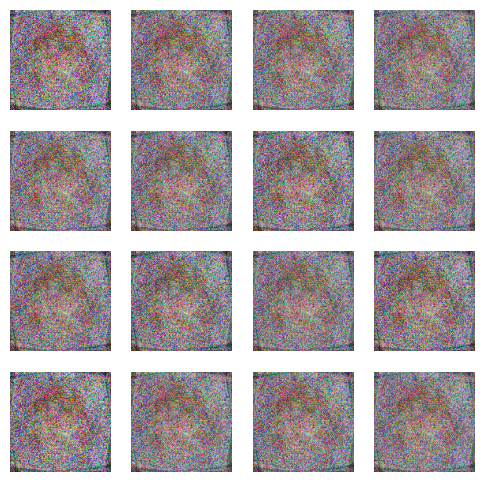

[Stage2:HAM10000_images_part_2] Epoch 1/3 | D:2.2753 | G:0.3363
[Stage2:HAM10000_images_part_2] Epoch 2/3 | D:2.0551 | G:0.3423
[Stage2:HAM10000_images_part_2] Epoch 3/3 | D:1.9418 | G:0.3649
Stage 2 models for HAM10000_images_part_2 saved.


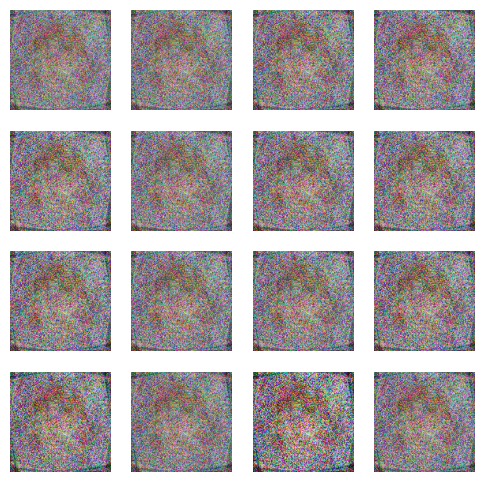

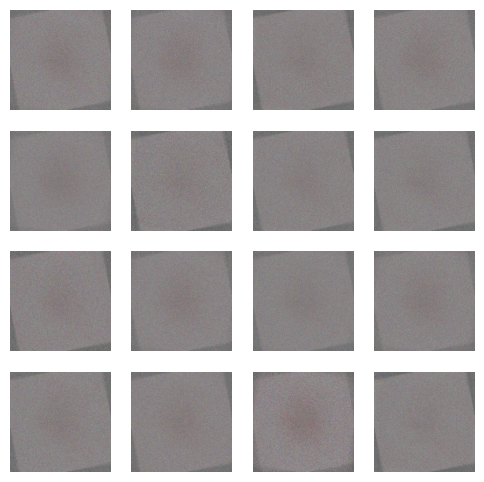

2-stage GAN training + image generation complete!


In [14]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ----------------------
# Dataset + Augmentations
# ----------------------
class CustomDataset(Dataset):
    def __init__(self, image_dirs, transform=None):
        self.image_paths = []
        for dir_path in image_dirs:
            self.image_paths += [os.path.join(dir_path, f) 
                                 for f in os.listdir(dir_path) 
                                 if f.lower().endswith(('.png','.jpg','.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ----------------------
# Generator + Discriminator
# ----------------------
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 3*128*128),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1,3,128,128)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*128*128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ----------------------
# Utilities
# ----------------------
def save_generated_images(generator, latent_dim, num_samples, fname):
    generator.eval()
    z = torch.randn(num_samples, latent_dim).cuda()
    with torch.no_grad():
        imgs = generator(z)
    save_image(imgs, fname, nrow=int(np.sqrt(num_samples)), normalize=True)
    return imgs

def imshow(img_tensor):
    img = img_tensor.cpu().numpy()
    img = np.transpose(img, (1,2,0))  # C,H,W -> H,W,C
    img = (img + 1)/2  # denormalize
    plt.imshow(img)
    plt.axis('off')

# ----------------------
# Two-stage training
# ----------------------
def train_stage1(dataloader, latent_dim=100, epochs=5, device="cuda"):
    G = Generator(latent_dim).to(device)
    D = Discriminator().to(device)
    criterion = nn.BCELoss()
    optG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
    optD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))

    for epoch in range(epochs):
        for imgs in dataloader:
            batch_size = imgs.size(0)
            real_imgs = imgs.to(device)

            # Discriminator
            optD.zero_grad()
            real_labels = torch.ones(batch_size,1).to(device) * 0.9
            fake_labels = torch.zeros(batch_size,1).to(device) + 0.1
            output_real = D(real_imgs + 0.05*torch.randn_like(real_imgs))
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = G(z)
            output_fake = D(fake_imgs.detach() + 0.05*torch.randn_like(fake_imgs))
            d_loss = criterion(output_real, real_labels) + criterion(output_fake, fake_labels)
            d_loss.backward()
            optD.step()

            # Generator
            optG.zero_grad()
            g_loss = criterion(D(fake_imgs), real_labels)
            g_loss.backward()
            optG.step()

        print(f"[Stage1] Epoch {epoch+1}/{epochs} | D:{d_loss.item():.4f} | G:{g_loss.item():.4f}")

    # Save models
    torch.save(G.state_dict(), "G_stage1.pth")
    torch.save(D.state_dict(), "D_stage1.pth")
    print("Stage 1 models saved.")
    return G, D

def freeze_discriminator_top(D, num_layers=1):
    count = 0
    for name, p in D.named_parameters():
        if 'weight' in name or 'bias' in name:
            if count < num_layers*2:  # weight+bias
                p.requires_grad = False
            count += 1

def train_stage2_per_class(class_folder, G_stage1_path, D_stage1_path, latent_dim=100, epochs=3, device="cuda"):
    G = Generator(latent_dim).to(device)
    D = Discriminator().to(device)
    G.load_state_dict(torch.load(G_stage1_path))
    D.load_state_dict(torch.load(D_stage1_path))

    freeze_discriminator_top(D, num_layers=1)

    ds = CustomDataset([class_folder], transform=transform)
    if len(ds)<4: return None,None
    dl = DataLoader(ds, batch_size=16, shuffle=True, drop_last=True)

    criterion = nn.BCELoss()
    optG = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5,0.999))
    optD = optim.Adam([p for p in D.parameters() if p.requires_grad], lr=0.00005, betas=(0.5,0.999))

    for epoch in range(epochs):
        for imgs in dl:
            batch_size = imgs.size(0)
            real_imgs = imgs.to(device)

            # D step
            optD.zero_grad()
            real_labels = torch.ones(batch_size,1).to(device) * 0.9
            fake_labels = torch.zeros(batch_size,1).to(device) + 0.1
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = G(z)
            output_real = D(real_imgs)
            output_fake = D(fake_imgs.detach())
            d_loss = criterion(output_real, real_labels) + criterion(output_fake, fake_labels)
            d_loss.backward()
            optD.step()

            # G step
            optG.zero_grad()
            g_loss = criterion(D(fake_imgs), real_labels)
            g_loss.backward()
            optG.step()

        print(f"[Stage2:{os.path.basename(class_folder)}] Epoch {epoch+1}/{epochs} | D:{d_loss.item():.4f} | G:{g_loss.item():.4f}")

    torch.save(G.state_dict(), f"G_stage2_{os.path.basename(class_folder)}.pth")
    torch.save(D.state_dict(), f"D_stage2_{os.path.basename(class_folder)}.pth")
    print(f"Stage 2 models for {os.path.basename(class_folder)} saved.")

    # Save synthetic images per class
    imgs = save_generated_images(G, latent_dim, num_samples=16, fname=f"synthetic_{os.path.basename(class_folder)}.png")

    # Visualize
    plt.figure(figsize=(6,6))
    for i in range(16):
        plt.subplot(4,4,i+1)
        imshow(imgs[i])
    plt.show()
    return G, D

# ----------------------
# Main
# ----------------------
data_dirs = [
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
]

dataset = CustomDataset(data_dirs, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# Stage 1: General GAN
G_stage1, D_stage1 = train_stage1(dataloader, epochs=5)

# Stage 2: Per-class fine-tuning + generate synthetic images + visualize
for cls_dir in data_dirs:
    train_stage2_per_class(cls_dir, "G_stage1.pth", "D_stage1.pth", epochs=3)

# ----------------------
# Generate new images from Stage1 GAN for general use
# ----------------------
new_imgs = save_generated_images(G_stage1, latent_dim=100, num_samples=16, fname="stage1_generated_samples.png")
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    imshow(new_imgs[i])
plt.show()
print("2-stage GAN training + image generation complete!")


[Classifier] Epoch 1/5 | Loss: 0.6813
[Classifier] Epoch 2/5 | Loss: 0.9300
[Classifier] Epoch 3/5 | Loss: 1.2525
[Classifier] Epoch 4/5 | Loss: 0.6439
[Classifier] Epoch 5/5 | Loss: 1.0168


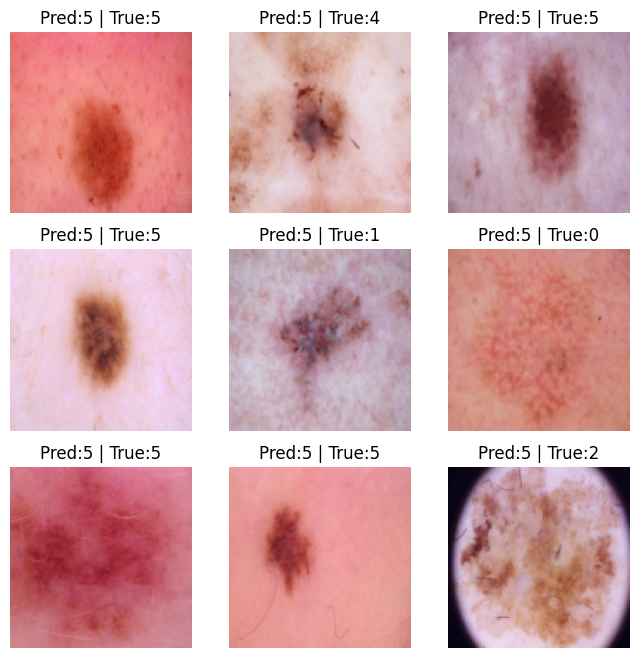

Classifier training complete with real+synthetic images!


In [20]:
# ---------------------- Markdown ----------------------
# # Step 3: Prepare Combined Dataset (Real + Synthetic) for Classifier

# ---------------------- Code ----------------------
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------
# Paths
# ----------------------
WORK_DIR = "./combined_data"
REAL_DIRS = [
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
]
META_CSV = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# ----------------------
# Read metadata for classes
# ----------------------
meta = pd.read_csv(META_CSV)
CLASS_NAMES = sorted(meta['dx'].unique())

# ----------------------
# Create combined folder structure
# ----------------------
os.makedirs(WORK_DIR, exist_ok=True)
for cls in CLASS_NAMES:
    os.makedirs(os.path.join(WORK_DIR, cls), exist_ok=True)

# ----------------------
# Copy real images into combined_data
# ----------------------
for idx, row in meta.iterrows():
    img_name = row['image_id'] + '.jpg'
    cls = row['dx']
    dst_dir = os.path.join(WORK_DIR, cls)
    src_path = None
    for real_dir in REAL_DIRS:
        tmp_path = os.path.join(real_dir, img_name)
        if os.path.exists(tmp_path):
            src_path = tmp_path
            break
    if src_path:
        shutil.copy(src_path, dst_dir)

# ----------------------
# Copy Stage 2 synthetic images (GAN outputs)
# Assumes saved as synthetic_<class>.png
# ----------------------
for cls in CLASS_NAMES:
    synth_file = f"synthetic_{cls}.png"
    if os.path.exists(synth_file):
        # Load the synthetic grid image and save it to combined_data folder
        img_grid = Image.open(synth_file)
        img_grid.save(os.path.join(WORK_DIR, cls, f"{cls}_stage2.png"))

# ----------------------
# Dataset class
# ----------------------
class CombinedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {cls:i for i, cls in enumerate(sorted(os.listdir(root_dir)))}
        for cls in os.listdir(root_dir):
            cls_folder = os.path.join(root_dir, cls)
            imgs_in_cls = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
            if len(imgs_in_cls)==0:
                print(f"Skipping empty class folder: {cls_folder}")
                continue
            for f in imgs_in_cls:
                self.image_paths.append(os.path.join(cls_folder,f))
                self.labels.append(self.class_to_idx[cls])
        self.transform = transform
        if len(self.image_paths)==0:
            raise ValueError(f"No images found in {root_dir}!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# ----------------------
# Transform & DataLoader
# ----------------------
clf_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = CombinedDataset(WORK_DIR, transform=clf_transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# ----------------------
# Simple CNN classifier
# ----------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ----------------------
# Train classifier
# ----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"[Classifier] Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

# ----------------------
# Visualize predictions
# ----------------------
imgs, labels = next(iter(dataloader))
outputs = model(imgs.to(device))
preds = torch.argmax(outputs, dim=1)
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(((imgs[i].permute(1,2,0)+1)/2).numpy())
    plt.title(f"Pred:{preds[i].item()} | True:{labels[i].item()}")
    plt.axis('off')
plt.show()
print("Classifier training complete with real+synthetic images!")


In [23]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)


In [24]:
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    return correct/total

val_acc = evaluate(model, val_loader, device)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


Validation Accuracy: 66.35%


Predictions: [5 4 5 5 5 5 5 5 2 5 5 2 5 5 5 4]
True Labels: [0 4 5 5 5 2 1 5 3 5 2 2 5 5 4 2]


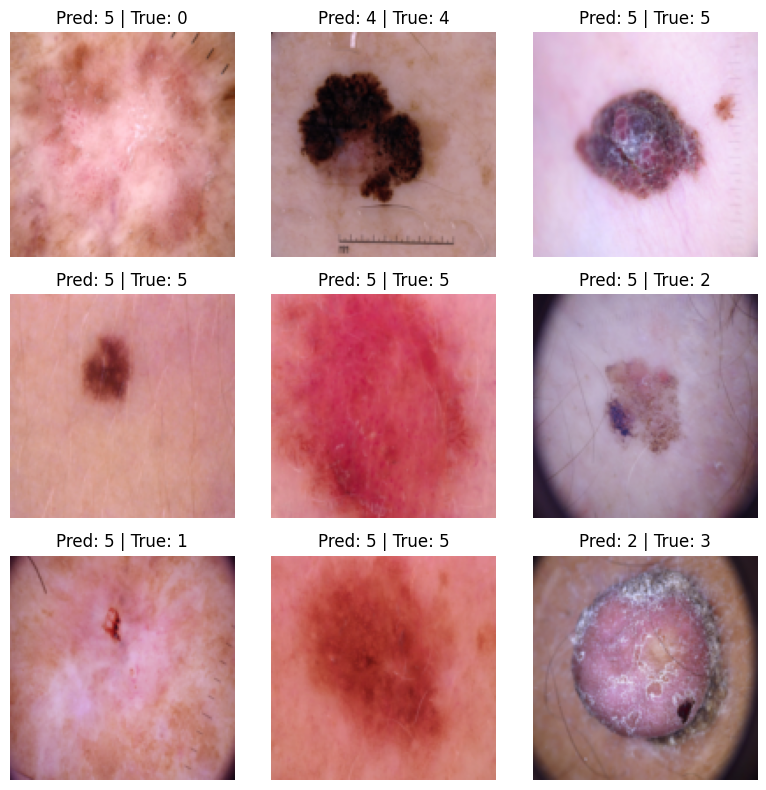

In [27]:
# ----------------------
# 1. Data Augmentation
# ----------------------
clf_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(128, scale=(0.8,1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ----------------------
# 2. Save Multiple Synthetic Images per Class
# ----------------------
def save_multiple_synthetic(G, latent_dim=100, num_samples=16, cls_name="mel", save_dir="./combined_data"):
    os.makedirs(os.path.join(save_dir, cls_name), exist_ok=True)
    G.eval()
    with torch.no_grad():
        for i in range(num_samples):
            z = torch.randn(1, latent_dim).cuda()
            img = G(z)
            save_image(img, os.path.join(save_dir, cls_name, f"{cls_name}_synth_{i}.png"), normalize=True)

# Example usage:
# save_multiple_synthetic(G_stage2_mel, latent_dim=100, num_samples=50, cls_name="mel")

# ----------------------
# 3. Save & Reload Classifier
# ----------------------
# Save
torch.save(model.state_dict(), "combined_cnn.pth")

# # ----------------------
# Reload saved classifier
# ----------------------
model = SimpleCNN(num_classes=len(CLASS_NAMES)).to(device)
model.load_state_dict(torch.load("combined_cnn.pth"))
model.eval()

# Optional: test on a batch to verify
imgs, labels = next(iter(dataloader))
outputs = model(imgs.to(device))
preds = torch.argmax(outputs, dim=1)
print("Predictions:", preds.cpu().numpy())
print("True Labels:", labels.numpy())



plt.figure(figsize=(8,8))
for i in range(min(9, len(imgs))):
    plt.subplot(3,3,i+1)
    img = ((imgs[i].permute(1,2,0)+1)/2).numpy()  # denormalize
    plt.imshow(img)
    plt.title(f"Pred: {preds[i].item()} | True: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()